### Try to determine how to reject vascular mask based on SNR of each slice in raw data

When SNR for a slice goes low, our vascular mask gets too large and is mostly noise

This uses aicsVascPost.py myRunPost() to calculate snr and vessel mask percent per slice.

This uses nathanGrid2 to plot the grid of max project.

### This is a two step process

1. run the code to make plots and determine snr and slice/depth threshold
2. run again using threshold and saving blanked mask (and raw) with myPoolRunner

see:

```
snrThresh = 50
sliceThresh = 50

indexList2, snrList2, maskCountList2, maskPercentList2 = myPoolRunner(path, snrThresh=snrThresh, sliceThresh=sliceThresh)
```

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, time, glob

import multiprocessing as mp

import numpy as np

sys.path.append(os.path.dirname(os.getcwd()))

from aicsVascPost import myRunPost # to calculate snr of raw and percent of vasc mask (per stack, per slice)

import nathanGrid2 # to fetch snaked file order given (row,col) grid and to plot it


/Users/cudmore/opt/anaconda3/envs/sami_env/lib/python3.6/site-packages/skan/csr.py:21: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @numba.jitclass(csr_spec)


## Run a number of stacks in parallel (on multiple cores)

For each slice in each stack, get

- snr
- mask count
- mask percentage

In [2]:
def myPoolRunner(path, snrThresh=None, sliceThresh=None, maskPercentThreshold=None):
    #path = '/Users/cudmore/box/data/nathan/20200518/analysisAics/20200518__A01_G001_*_ch2.tif'
    indexList = []
    snrList = []
    maskCountList = []
    maskPercentList = []

    filenames = glob.glob(path)
    print('proccessing', len(filenames), 'files')

    startTime = time.time()

    cpuCount = mp.cpu_count() - 2
    pool = mp.Pool(processes=cpuCount)
    results = [pool.apply_async(myRunPost, args=(file,myIdx+1,snrThresh,sliceThresh,maskPercentThreshold)) for myIdx, file in enumerate(filenames)]
    
    # get the results
    for idx, result in enumerate(results):
        returnIdx, snrList0, maskCountList0, maskPercentList0 = result.get()
        
        indexList.append(returnIdx)
        snrList.append(snrList0)
        maskCountList.append(maskCountList0)
        maskPercentList.append(maskPercentList0)
    
    #
    stopTime = time.time()
    print('finished in', round(stopTime-startTime,2), 'seconds')

    print(len(maskCountList))

    print('indexList:', indexList)
    
    return indexList, snrList, maskCountList, maskPercentList


In [3]:
path = '/Users/cudmore/box/data/nathan/20200518/analysisAics/20200518__A01_G001_*_ch2.tif'
indexList, snrList, maskCountList, maskPercentList = myPoolRunner(path)


proccessing 48 files
finished in 5.8 seconds
48
indexList: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


## We need this to get fileIdxList, the snaked files

myMakeGrid() commonShape: (64, 512, 512)
please wait ... folderPath: /Users/cudmore/box/data/nathan/20200518/analysisAics


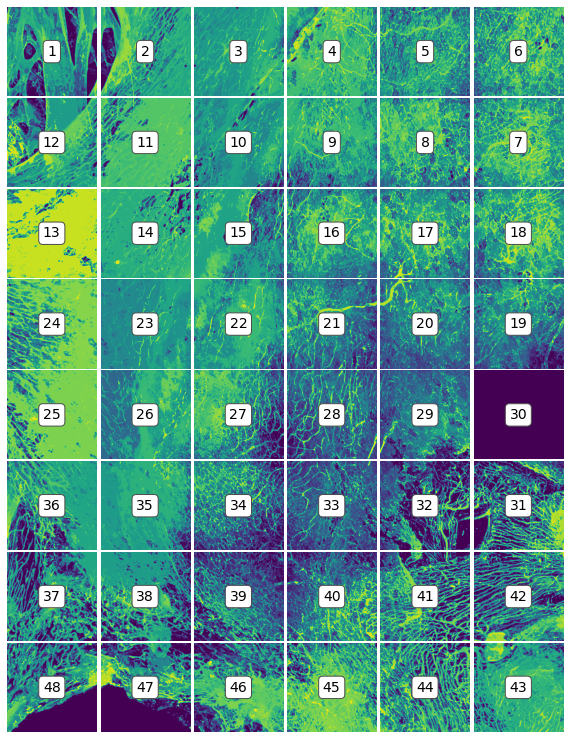

In [4]:
# raw
#folderPath = '/Users/cudmore/box/data/nathan/20200518'

# aics post-process
folderPath = '/Users/cudmore/box/data/nathan/20200518/analysisAics'

prefixStr = '20200518__A01_G001_'
nRow = 8
nCol = 6

# specify the channel
channel = 1
channel = 2 # does not look so good for CD-31 because of endocardium

tifDataList, tifMaxList, fileNameList, fileIdxMatrix = nathanGrid2.myMakeGrid(folderPath, prefixStr, channel, nRow, nCol)

fileIdxList = fileIdxMatrix.ravel() # flatten 2d to 1d, we still need to know (nRow, nCol)

plotLabels = True
wSpace = 0.02 # a little white space between stacks
hSpace = 0.02
#wSpace = -0.1 # to remove border
#hSpace = -0.1
nathanGrid2.plotGrid(folderPath, nRow, nCol, fileNameList, fileIdxList, tifMaxList, plotLabels, wSpace, hSpace)


In [5]:
import matplotlib.pyplot as plt

plt.style.use("dark_background") # seaborn-paper

import matplotlib
params = {'legend.fontsize': 18,
      'axes.labelsize': 18,
      'axes.titlesize': 18,
      'ytick.labelsize' :14,
      'xtick.labelsize' :14,
      "xtick.bottom" : True,
      "ytick.left" : True,
      }
matplotlib.rcParams.update(params)

In [8]:

def myPlotDepth(nRow, nCol, snrList, maskPercentList, fileIdxList):
    """
    purpose: plot snr and mask percent as a function of slice/depth for each stack in a grid
    
    parameters:
        fileIdxList: snaked file index, 1 based
    """
    
    # choose a width (in inches) and we will calculate a respective height
    figWidth = 25 #nCol
    #figHeight = nRow
    heightMult = nRow / nCol
    figHeight = figWidth * heightMult

    # make (nRow x nCol) subplots
    fig, axs = plt.subplots(nrows=nRow, ncols=nCol,
                            sharex=True, sharey=True, figsize=(figWidth,figHeight), constrained_layout=False)
    if nRow>1 and nCol>1:
        # flatten 2d plot list
        axs = axs.ravel() # flatten all subplots into [0, 1, 2, ...]
    else:
        axs = [axs] # make one plot a list
        
    myLineWidth = 5
    snrThreshold = 0 # 20200731
    
    print('red: snr, white: mask count')
    
    x_snrMax = 0
    x_maskMax = 0
    
    # loop to do plots
    subplotIdx = 0
    secondAxesList = []
    for idx, fileIdx in enumerate(fileIdxList):
        #print(fileIdx)
        plotIdx = fileIdx - 1 # matplotlib is 0 based, our file names are 1 based
        sliceList = [x for x in range(len(snrList[plotIdx]))]
        numSlices = len(sliceList)
        
        snrMax = np.nanmax(snrList[plotIdx])
        if snrMax > x_snrMax:
            x_snrMax = snrMax

        maskMax = np.nanmax(maskPercentList[plotIdx])
        if maskMax > x_maskMax:
            x_maskMax = maskMax
        
        # left axis is snr
        axs[subplotIdx].plot(snrList[plotIdx], sliceList, linewidth=myLineWidth, color='r')

        axs[subplotIdx].axvline(x=snrThreshold, color='r', linewidth=myLineWidth-1, linestyle='--')
        
        # top axis is mask count
        ax2 = axs[subplotIdx].twiny()
        secondAxesList.append(ax2)

        #l2, = secondAxesList[plotIdx].plot(oneHullFraction, sliceList, linewidth=myLineWidth, color='w')
        l2, = secondAxesList[subplotIdx].plot(maskPercentList[plotIdx], sliceList, linewidth=myLineWidth, color='w')
 
        # reverse the y-axis (slices)
        axs[subplotIdx].set_ylim(numSlices, 0) # 
        secondAxesList[subplotIdx].set_ylim(numSlices,0) # 

        labeltop = idx < nCol
        #print(idx, nCol, labeltop)
        secondAxesList[subplotIdx].tick_params(axis='x', colors='w', labeltop=labeltop)
        
        axs[subplotIdx].tick_params(axis='x', colors='r')
        
        subplotIdx += 1
        
    # Pad each stack with some border white space
    #plt.subplots_adjust(wspace=wSpace, hspace=hSpace)

    print('setting all x-axis the same, x_snrMax:', x_snrMax, 'x_maskMax:', x_maskMax)
    for idx in range(len(axs)):
        axs[idx].set_xlim(0, x_snrMax) # so each plot looks same
        secondAxesList[idx].set_xlim(0, x_maskMax) # so each plot looks same


### Look at snr of each slice and number of pixels in vessel mask (e.g. # of # pixels in image)
                                                               
### Use this to determine an SNR cutt-off
                                                            
### Given the above, it seems we need to remove vessel mask slices when image (at same slice) has intentisty range <50

### Use 2 rules:

 - snr < 50 and slice>50

red: snr, white: mask count
setting all x-axis the same, x_snrMax: 240 x_maskMax: 0.6074180603027344


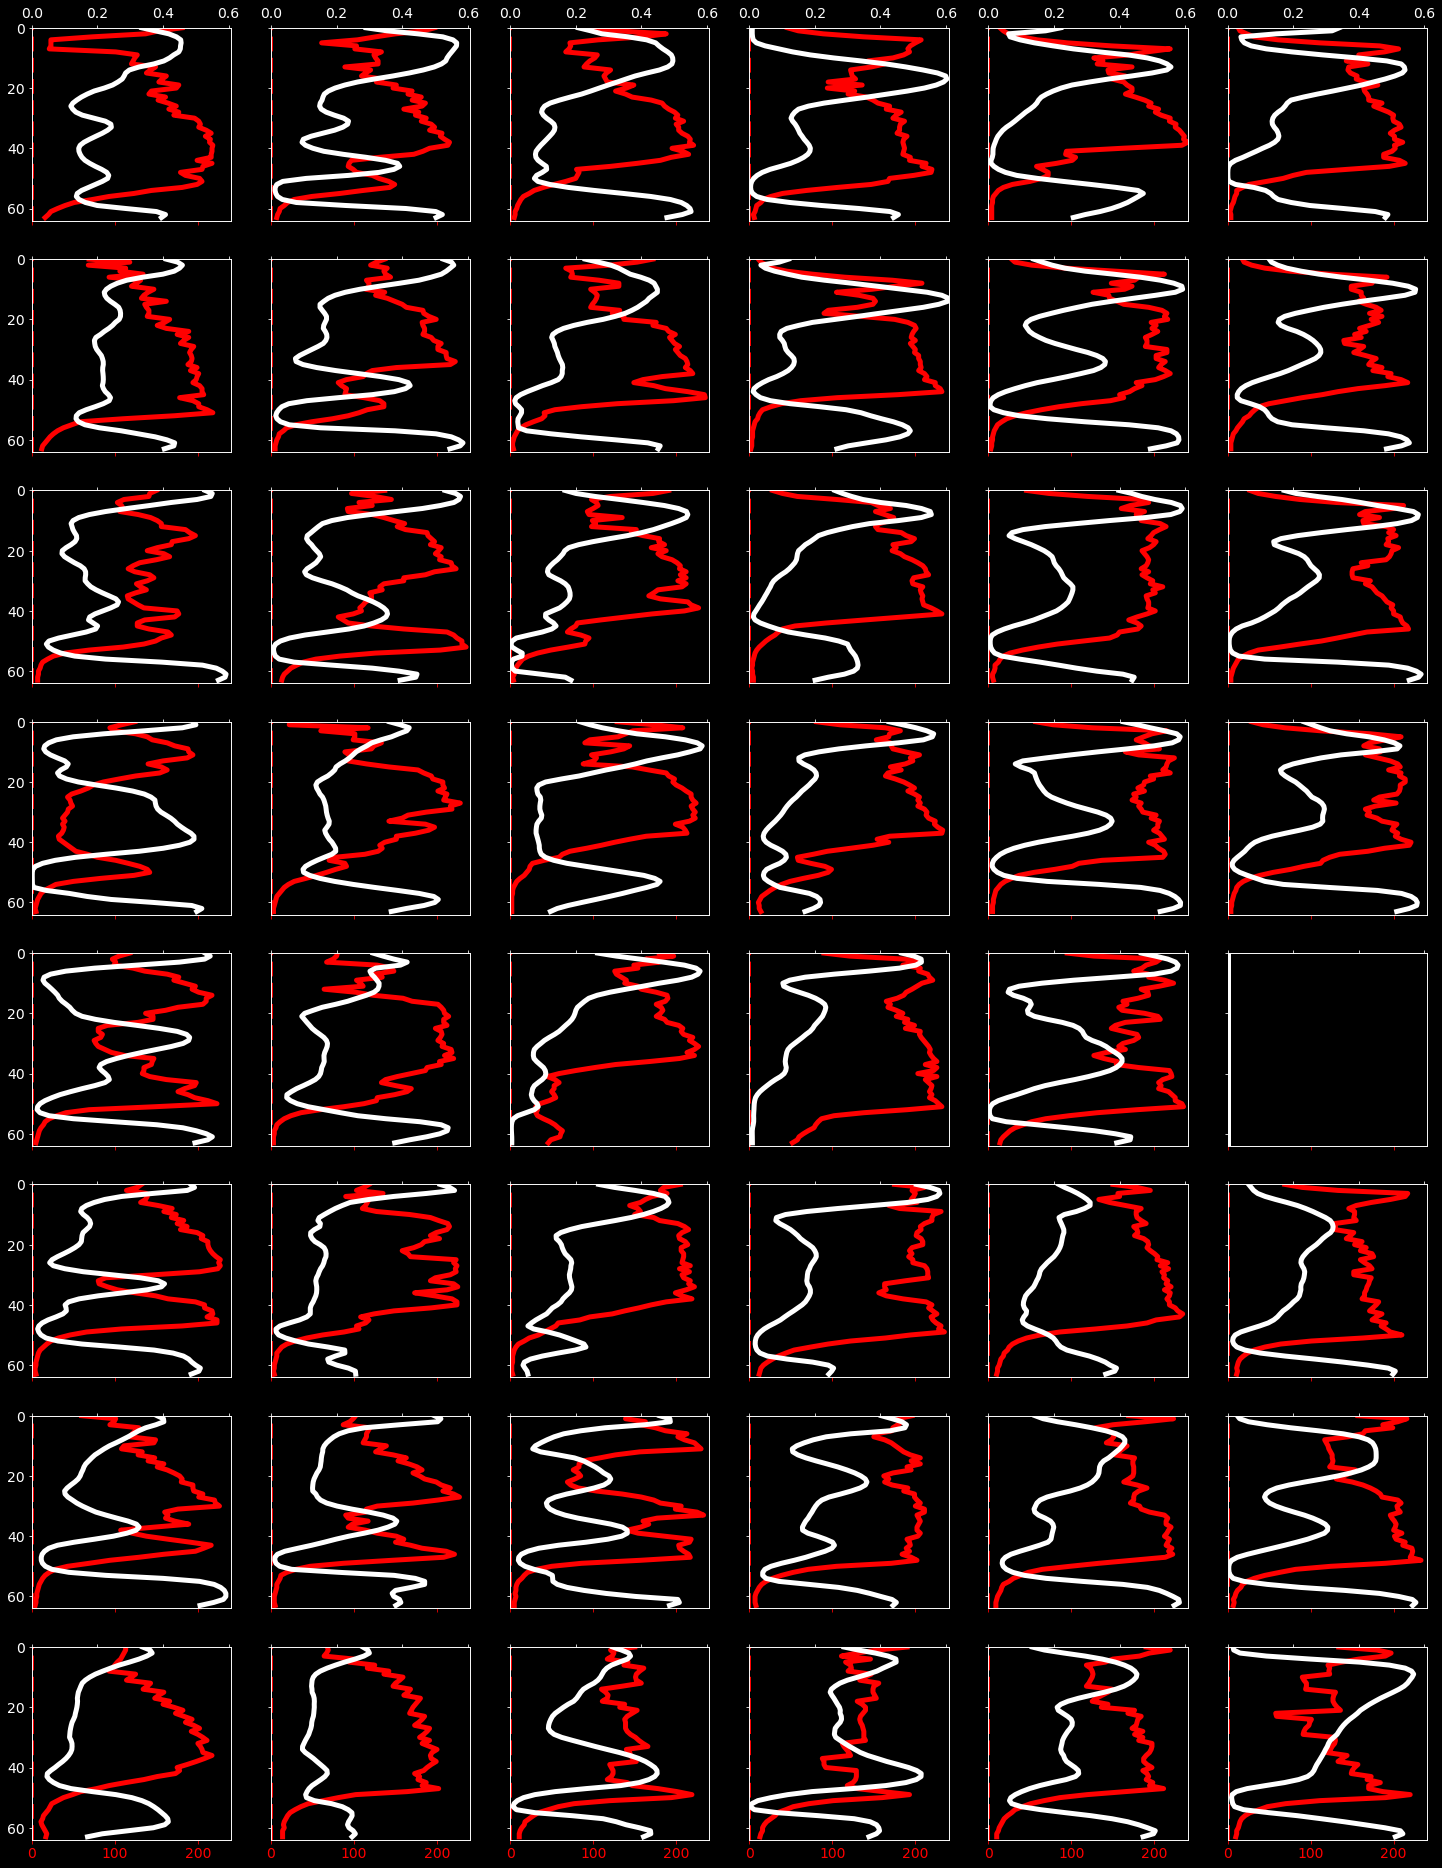

In [9]:
# to plot one
nRow = 1
nCol = 1

nRow = 8
nCol = 6

myPlotDepth(nRow, nCol, snrList, maskPercentList, fileIdxList)

Given the above, it seems we need to remove vessel mask slices when image (at same slice) has intentisty range <50

## Run again with determined threshold and actually save blanked out masks to new folder

In [65]:
snrThresh = 50
sliceThresh = 50
maskPercentThreshold = 0.2
indexList2, snrList2, maskCountList2, maskPercentList2 = \
    myPoolRunner(path, snrThresh=snrThresh, sliceThresh=sliceThresh, maskPercentThreshold=maskPercentThreshold)


proccessing 48 files
finished in 12.95 seconds
48
indexList: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


red: snr, white: mask count
setting all x-axis the same, x_snrMax: 240 x_maskMax: 0.2999916076660156


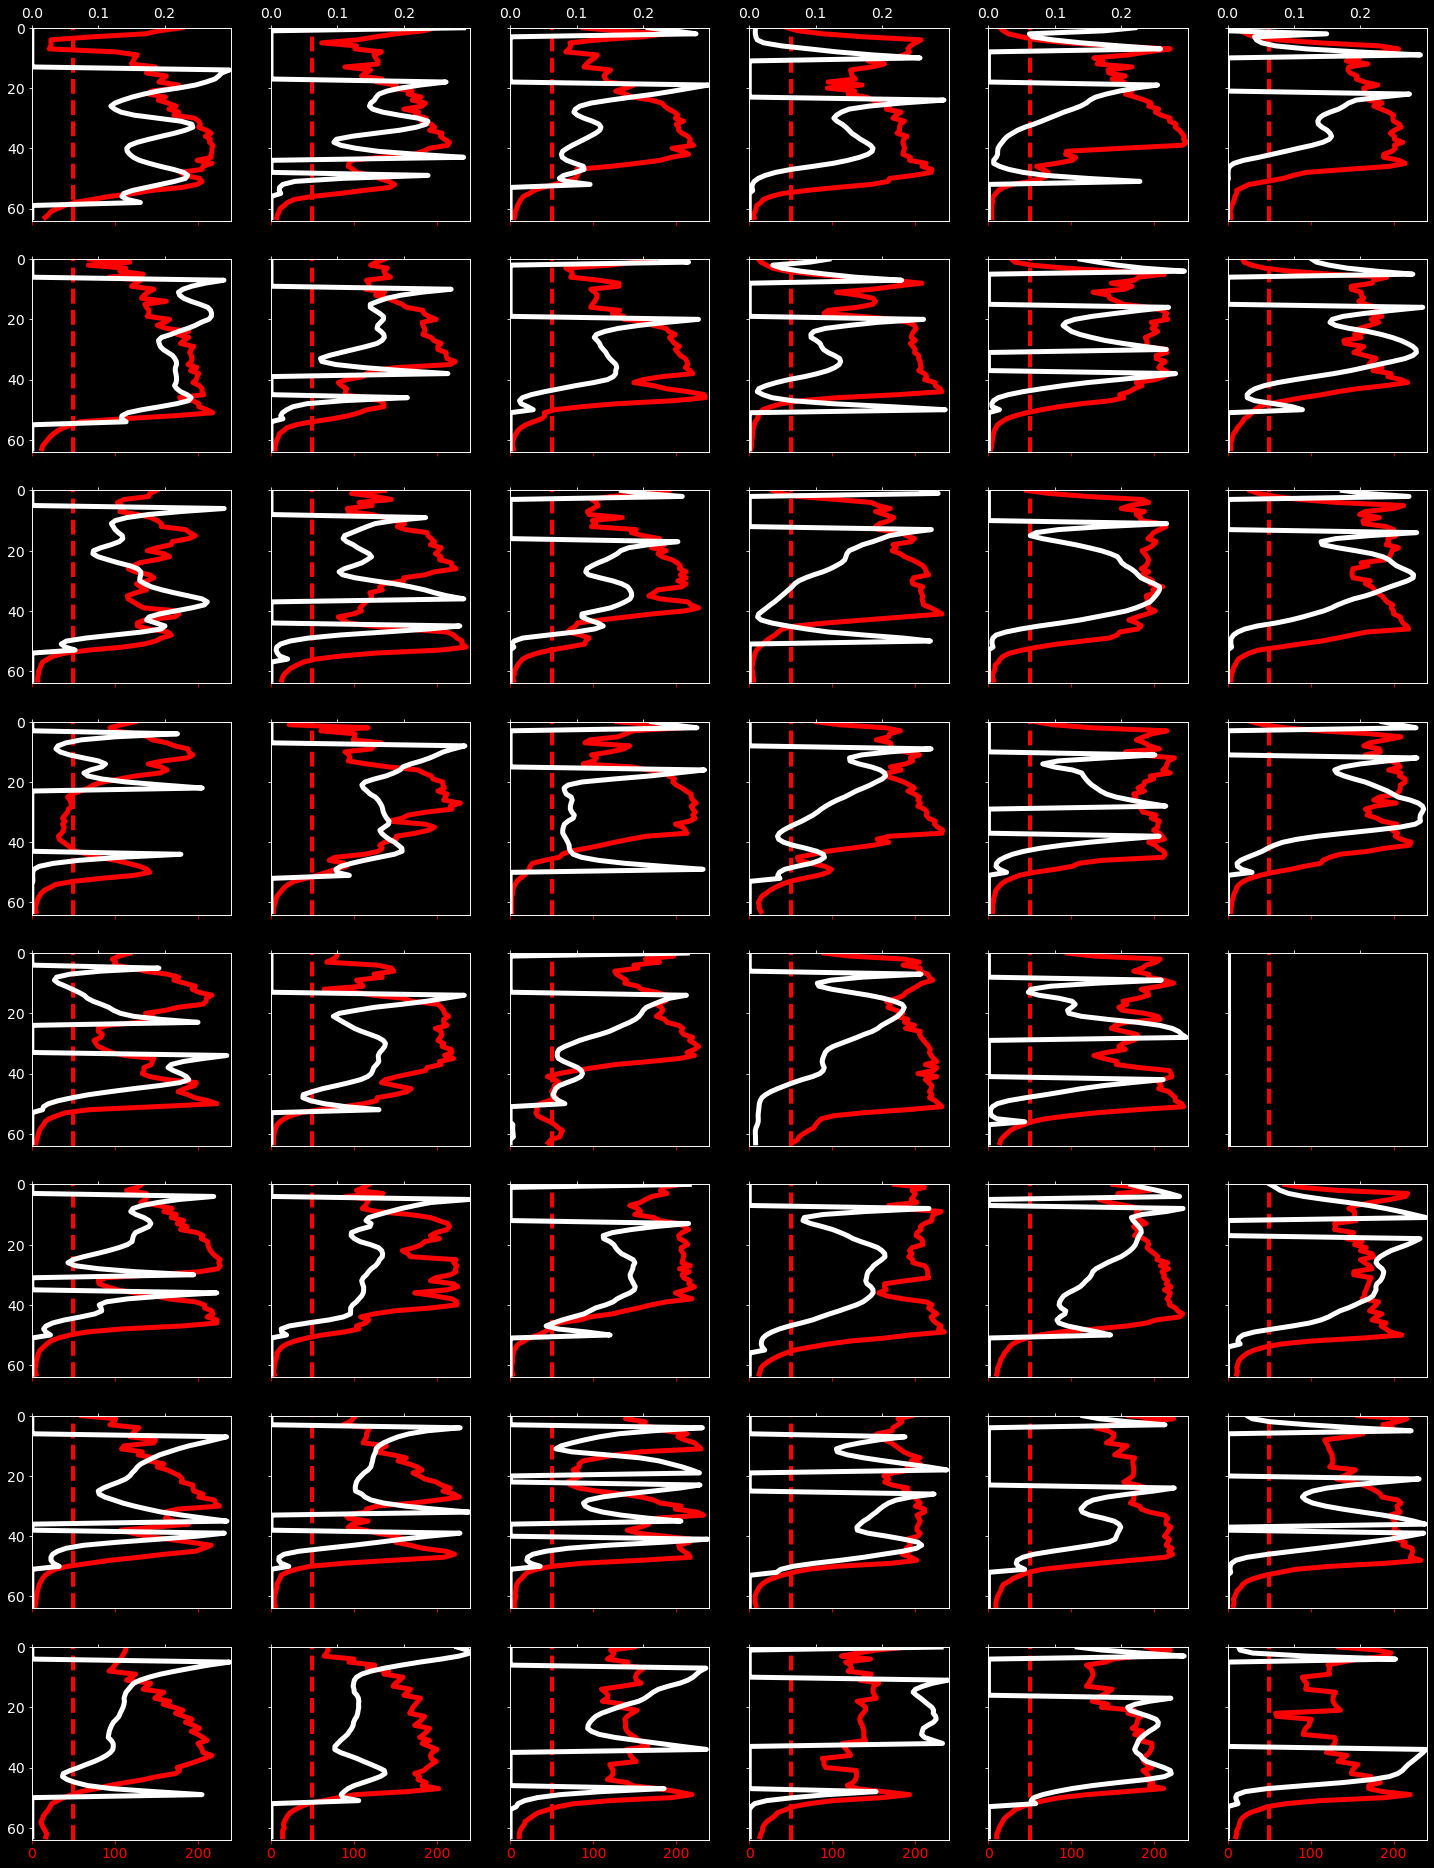

In [66]:
# plot again
myPlotDepth(nRow, nCol, snrList2, maskPercentList2, fileIdxList)

## Reload the raw and new blanked mask files from 'analysisAicsPost'

In [50]:
blankedPath = '/Users/cudmore/box/data/nathan/20200518/analysisAicsPost/20200518__A01_G001_*_ch2.tif'
indexList3, snrList3, maskCountList3, maskPercentList3 = myPoolRunner(blankedPath)


proccessing 48 files
finished in 5.95 seconds
48
indexList: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


myMakeGrid() commonShape: (64, 512, 512)
red: snr, white: mask count
setting all x-axis the same, x_snrMax: 240 x_maskMax: 0.6074180603027344


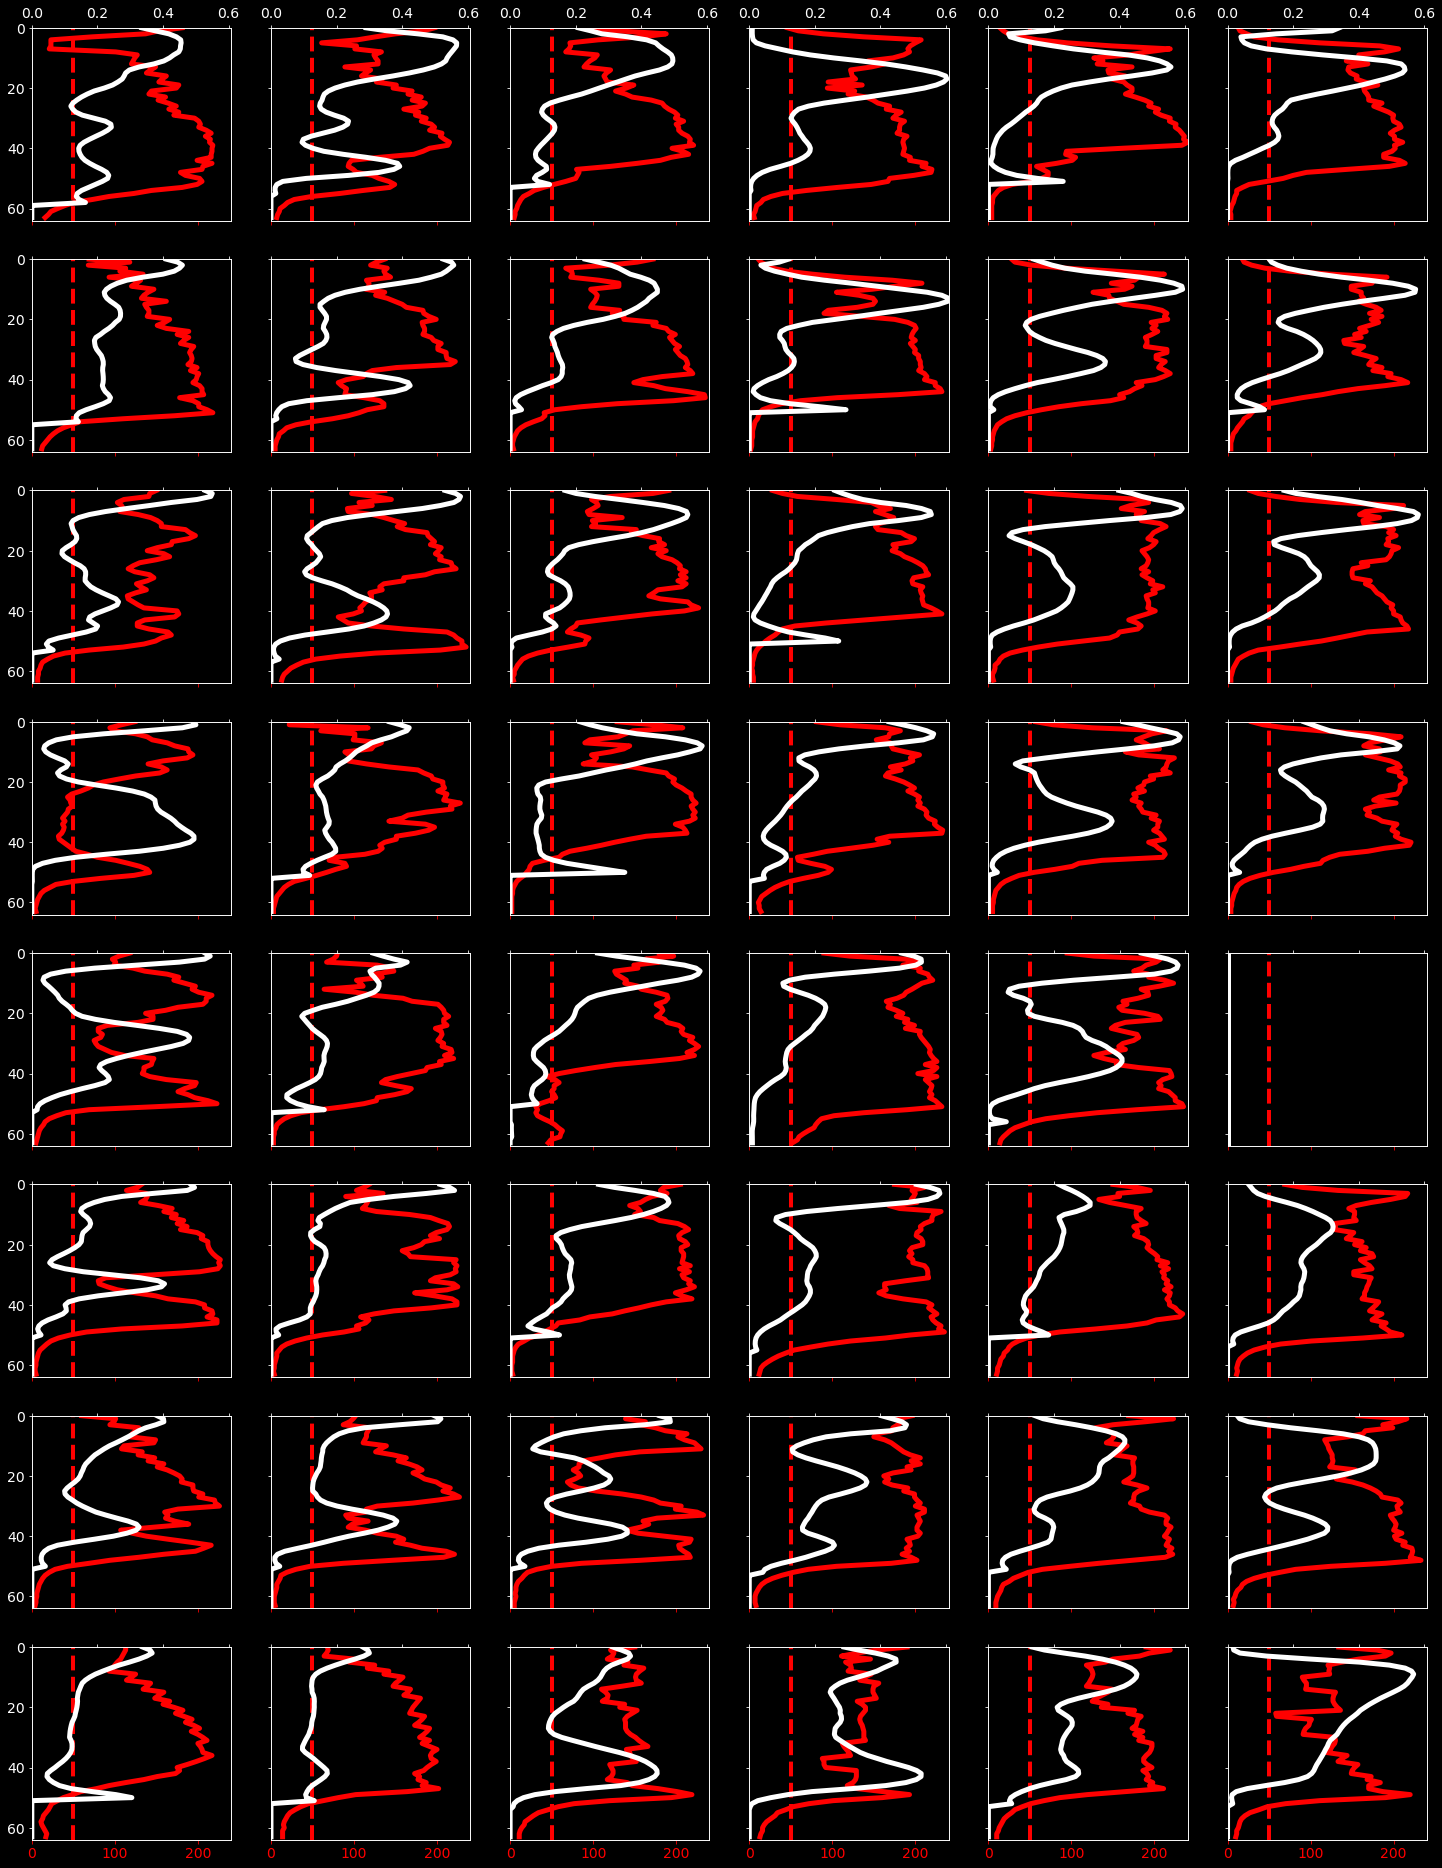

In [51]:
tifDataList, tifMaxList, fileNameList, fileIdxMatrix = nathanGrid2.myMakeGrid(folderPath, prefixStr, channel, nRow, nCol)

fileIdxList = fileIdxMatrix.ravel() # flatten 2d to 1d, we still need to know (nRow, nCol)

## And plot again
myPlotDepth(nRow, nCol, snrList3, maskPercentList3, fileIdxList)

## view the results in Napari

`analysisAicsPost/` folder has the blanked out mask based on snr and depth thresholds


## 20200625, this is super depressing as it looks like complete shit !!!!

In [55]:
import myDaskNapari

myGridParams = myDaskNapari.getDaskGridDict()
myGridParams['path'] = '/Users/cudmore/box/data/nathan/20200518/analysisAicsPost'
myGridParams['prefixStr'] = '20200518__A01_G001_'
myGridParams['channelList'] = [2]
myGridParams['commonShape'] = (62,512,512)
myGridParams['commonVoxelSize'] = (1, 0.621480865, 0.621480865)
myGridParams['trimPercent'] = 15
myGridParams['trimPixels'] = None # calculated
myGridParams['nRow'] = nRow
myGridParams['nCol'] = nCol
myGridParams['finalPostfixList'] = ['', 'mask'] # using '' gives us raw, mask gives us _mask.tif


myDaskNapari.openDaskNapari2(myGridParams)

myDaskNapari()
{
    "path": "/Users/cudmore/box/data/nathan/20200518/analysisAicsPost",
    "prefixStr": "20200518__A01_G001_",
    "finalPostfixStr": "",
    "channelList": [
        2
    ],
    "commonShape": [
        62,
        512,
        512
    ],
    "commonVoxelSize": [
        1,
        0.621480865,
        0.621480865
    ],
    "trimPercent": 15,
    "trimPixels": null,
    "nRow": 8,
    "nCol": 6,
    "finalPostfixList": [
        "",
        "mask"
    ]
}
(62, 3792, 2844) theMin: 0 theMax: 243
